before


Using TensorFlow backend.


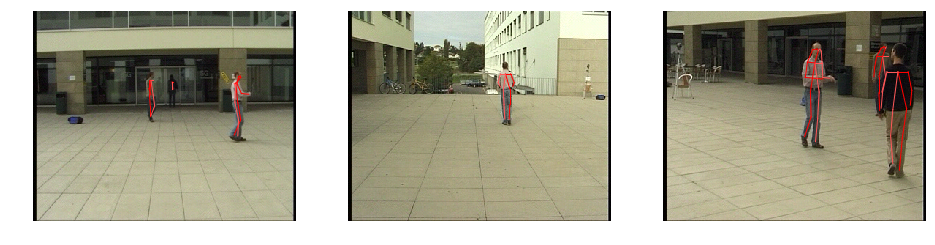

In [1]:
%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
sys.path.insert(0,'../debugging')
from mvpose.data import epfl_campus
from time import time

root = Settings['data_root']
root = join(root, 'pak')
tmp = Settings['tmp']

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp
from mvpose.plot.limbs import draw_mscoco_human, draw_mscoco_human2d

from openpose import OpenPose

FRAME = 660
pe = OpenPose(tmp=tmp)
Im, Y, Calib = epfl_campus.get(root, FRAME)
predictions = pe.predict(Im, 'cvpr_campus', FRAME)


fig = plt.figure(figsize=(16, 8))
for idx, (im, pred) in enumerate(zip(Im, predictions)):
    ax = fig.add_subplot(1, 3, idx+1); ax.axis('off')
    ax.imshow(im)
    
    for human in pred:
        draw_mscoco_human2d(ax, human[:, 0:2], color='red')

plt.show()

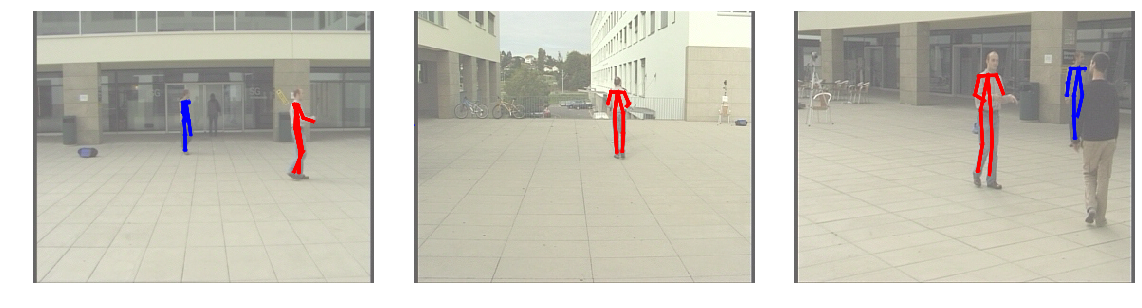

In [2]:
from mvpose.baseline.baseline import estimate

H = estimate(Calib, predictions, epi_threshold=20)

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green', 'teal']

for cid, cam in enumerate(Calib):
    ax = fig.add_subplot(1, 3, 1+cid)
    ax.axis('off')
    im = Im[cid]
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.imshow(im, alpha=0.6)
    
    for pid, hyp in enumerate(H):
        draw_mscoco_human(ax, hyp, cam, alpha=0.5,
                          color=colors[pid], linewidth=3)
    
plt.tight_layout()
plt.show()

In [3]:
# =====================================
def generate_pcp_score(frame):
    global pe
    alpha = 0.5
    Im, Y, Calib = epfl_campus.get(root, frame)
    predictions = pe.predict(Im, 'cvpr_campus', frame)
    detections = estimate(Calib, predictions, epi_threshold=10)
    Humans = kth.transform3d_from_mscoco(detections)
    
    L_Arms = []
    U_Arms = []
    L_Legs = []
    U_Legs = []
    GTIDs = []
  
    for gtid, gt in enumerate(Y):
        if gt is None:
            continue
        
        larms = 0
        uarms = 0
        llegs = 0
        ulegs = 0
        avg = 0
        for d in Humans:
            r = pcp.evaluate(gt, d, alpha)
            larms_ = r.lower_arms
            uarms_ = r.upper_arms
            ulegs_ = r.upper_legs
            llegs_ = r.lower_legs
            avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
            if avg_ > avg:
                avg = avg_
                larms = larms_
                uarms = uarms_
                llegs = llegs_
                ulegs = ulegs_
        
        L_Arms.append(larms)
        U_Arms.append(uarms)
        L_Legs.append(llegs)
        U_Legs.append(ulegs)
        GTIDs.append(gtid)
    
    return L_Arms, U_Arms, L_Legs, U_Legs, GTIDs

# =====================================

valid_frames = list(range(350, 470)) + list(range(650, 750))
PER_GTID = {}

for frame in valid_frames:
    _start = time()
    L_Arms, U_Arms, L_Legs, U_Legs, GTIDs = generate_pcp_score(frame)
    _end = time()
    print('frame ' + str(frame) + ', elapsed:', _end - _start)
    
    if len(L_Arms) > 0:
        for gtid, larms, uarms, llegs, ulegs in zip(
            GTIDs, L_Arms, U_Arms, L_Legs, U_Legs
        ):
            if not gtid in PER_GTID:
                PER_GTID[gtid] = {
                    'larms': [],
                    'uarms': [],
                    'llegs': [],
                    'ulegs': [],
                    'frame': []
                }
            PER_GTID[gtid]['larms'].append(larms)
            PER_GTID[gtid]['uarms'].append(uarms)
            PER_GTID[gtid]['llegs'].append(llegs)
            PER_GTID[gtid]['ulegs'].append(ulegs)
            PER_GTID[gtid]['frame'].append(frame)
    

frame 350, elapsed: 0.07874870300292969
frame 351, elapsed: 0.06572461128234863
frame 352, elapsed: 0.06545162200927734
frame 353, elapsed: 0.06351852416992188
frame 354, elapsed: 0.06559181213378906
frame 355, elapsed: 0.06585478782653809
frame 356, elapsed: 0.06405067443847656
frame 357, elapsed: 0.06604123115539551
frame 358, elapsed: 0.06778836250305176
frame 359, elapsed: 0.06429624557495117
frame 360, elapsed: 0.06248760223388672
frame 361, elapsed: 0.06532859802246094
frame 362, elapsed: 0.06711769104003906
frame 363, elapsed: 0.06388664245605469
frame 364, elapsed: 0.06485176086425781
frame 365, elapsed: 0.06412887573242188
frame 366, elapsed: 0.06551718711853027
frame 367, elapsed: 0.06304740905761719
frame 368, elapsed: 0.06376981735229492
frame 369, elapsed: 0.06379485130310059
frame 370, elapsed: 0.13716554641723633
frame 371, elapsed: 0.06359171867370605
frame 372, elapsed: 0.06375527381896973
frame 373, elapsed: 0.0653676986694336
frame 374, elapsed: 0.06587958335876465
f

frame 738, elapsed: 0.07588529586791992
frame 739, elapsed: 0.07553982734680176
frame 740, elapsed: 0.07358241081237793
frame 741, elapsed: 0.0763084888458252
frame 742, elapsed: 0.07938337326049805
frame 743, elapsed: 0.0782003402709961
frame 744, elapsed: 0.09036803245544434
frame 745, elapsed: 0.08886909484863281
frame 746, elapsed: 0.08162260055541992
frame 747, elapsed: 0.07724642753601074
frame 748, elapsed: 0.07610869407653809
frame 749, elapsed: 0.07687115669250488


In [4]:
total_avg = []
for key, values in PER_GTID.items():
    print('actor ', key)
    print('\tuarms:', np.mean(values['uarms']))
    print('\tlarms:', np.mean(values['larms']))
    print('\tulegs:', np.mean(values['ulegs']))
    print('\tllegs:', np.mean(values['llegs']))
    avg = np.mean([
        np.mean(values['uarms']),
        np.mean(values['larms']),
        np.mean(values['ulegs']),
        np.mean(values['llegs'])
    ])
    total_avg.append(avg)
    print('\tavg:  ', avg)
print('\navg*:  ', np.mean(total_avg))

actor  1
	uarms: 0.9920212765957447
	larms: 0.5611702127659575
	ulegs: 0.9946808510638298
	llegs: 0.9946808510638298
	avg:   0.8856382978723405
actor  2
	uarms: 0.8235294117647058
	larms: 0.5955882352941176
	ulegs: 0.9816176470588235
	llegs: 0.9816176470588235
	avg:   0.8455882352941175
actor  0
	uarms: 0.59375
	larms: 0.4479166666666667
	ulegs: 1.0
	llegs: 1.0
	avg:   0.7604166666666667

avg*:   0.8305477332777084
